In [1]:
import os

In [2]:
!pwd

/home/jovyan/notebooks/analysis/benchmarking_against_NAS


In [3]:
import sys
sys.path.append('/home/jovyan/')

In [4]:
from experiments.reporting.report_repository import ReportRepository
from experiments.slack_client import SlackNotifier
from neat.neat_logger import get_neat_logger
from neat.population_engine import EvolutionEngine
from neat.reporting.reports_pyneat import EvolutionReport
from neat.utils import timeit
import math
import random
from itertools import count
import numpy as np

from experiments.logger import logger
from experiments.slack_client import Notifier
from experiments.object_repository.object_repository import ObjectRepository
from experiments.reporting.report_repository import ReportPathFactory
from neat.configuration import get_configuration
from neat.evaluation.evaluation_engine import EvaluationStochasticEngine
from neat.evolution_operators.crossover import Crossover
from neat.evolution_operators.mutation import Mutation
from neat.genome import Genome
from neat.reporting.reports_pyneat import EvolutionReport
from neat.species import SpeciationEngine
from neat.stagnation import Stagnation
from neat.population_engine import PopulationEngine
from neat.utils import timeit
import neat
import tests
from config_files.configuration_utils import create_configuration
from neat.configuration import get_configuration, set_configuration
from neat.evaluation.evaluation_engine import get_dataset
from neat.evaluation.evaluate_simple import evaluate_genome, calculate_prediction_distribution
from neat.genome import Genome
from neat.evolution_operators.backprop_mutation import BackPropMutation
import os
from neat.loss.vi_loss import get_loss
import torch
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from neat.analysis.experiment_data import ExperimentData
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimator
from neat.analysis.plotting.plot_losses import plot_loss_distribution
from neat.analysis.plotting.plot_classification_metrics import plot_metrics_by_quantile_several_executions
from neat.analysis.experiment_predictive_distributions import ExecutionsPredictionDistributions

In [7]:
LOGS_PATH = f'{os.getcwd()}/'
logger = get_neat_logger(path=LOGS_PATH)

In [13]:
PROJECT = 'neuro-evolution'
ALGORITHM_VERSION = 'bayes-neat'
DATASET = 'iris'

# correlation_ids = [f'neat_ft_1_{DATASET}', f'bayesian_neat_ft_1_{DATASET}']
correlation_ids = [f'bayesian_neat_ft_4_{DATASET}'] 

In [33]:
# from IPython.core.debugger import set_trace
# set_trace()
experiment_data_ne = ExperimentData(correlation_ids=correlation_ids, dataset_name=DATASET, n_samples=1000,
                                 project=PROJECT, algorithm_version=ALGORITHM_VERSION,
                                keep_top=1.0)\
                    .process_data()
data_ne = experiment_data_ne.get_experiment_data()
data_ne = data_ne.loc[data_ne['noise'] == 0.0]
data_ne['version'] = 'Bayesian Neuro-Evolution'
data_ne.head()

###########
CORRELATION ID: bayesian_neat_ft_4_iris
Fitness of best individual: -0.24178801476955414
Train percentage: 0.75
Random state: 13
Sum Train: -22.258182525634766
Training: 112. Testing: 38
Fitness of best individual: -0.2915726602077484
Train percentage: 0.75
Random state: 66
Sum Train: 1.8473572731018066
Training: 112. Testing: 38
Fitness of best individual: -0.31694719195365906
Train percentage: 0.75
Random state: 62
Sum Train: -1.7831287384033203
Training: 112. Testing: 38
Fitness of best individual: -0.26626986265182495
Train percentage: 0.75
Random state: 69
Sum Train: -7.9701128005981445
Training: 112. Testing: 38
Fitness of best individual: -0.049147412180900574
Train percentage: 0.75
Random state: 79
Sum Train: -6.6297197341918945
Training: 112. Testing: 38
Fitness of best individual: -0.3322971761226654
Train percentage: 0.75
Random state: 9
Sum Train: 20.69968605041504
Training: 112. Testing: 38
Fitness of best individual: -0.04197879508137703
Train percentage: 0.75

/home/jovyan/neat/analysis/experiment_data.py:186: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  executions_per_experiment = experiment_data.groupby(filtering_group)['execution_id'].nunique().reset_index()\
/home/jovyan/neat/analysis/experiment_data.py:193: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  for filtering_group_values, experiment_data_per_correlation_id in experiment_data.groupby(filtering_group):
/home/jovyan/neat/analysis/experiment_data.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment_data_per_correlation_id.sort_v

,correlation_id,execution_id,train_percentage,noise,is_bayesian,beta,loss_training,loss_testing,duration,end_condition,n_parameters,n_nodes,n_connections,mean_genome_std,accuracy,f1,version
0,bayesian_neat_ft_4_iris,c76c074e-ceb0-4b3c-916d-93e6edd4da1d,0.75,0.0,True,0.000001,0.022904,0.158387,0:04:57.346098,normal,94,15,32,0.506097,95.410526,0.954199,Bayesian Neuro-Evolution
1,bayesian_neat_ft_4_iris,aa377825-38f8-40c6-8613-42fe3c27411a,0.75,0.0,True,0.000001,0.031147,0.531243,0:11:48.839582,normal,170,28,57,0.908474,86.792105,0.868889,Bayesian Neuro-Evolution
2,bayesian_neat_ft_4_iris,5837886a-430c-4c6e-ba85-e499f2b323bc,0.75,0.0,True,0.000001,0.041979,0.112475,0:08:07.872646,normal,136,22,46,0.927758,93.563158,0.936056,Bayesian Neuro-Evolution
3,bayesian_neat_ft_4_iris,42413abb-186a-4500-9aa7-f74f3619ba4c,0.75,0.0,True,0.000001,0.049147,0.094947,0:04:09.267670,normal,100,15,35,0.560648,96.981579,0.969852,Bayesian Neuro-Evolution
4,bayesian_neat_ft_4_iris,fa49146a-44c8-4001-b17a-c8fa40c91fee,0.75,0.0,True,0.000001,0.077685,0.120355,0:23:22.603487,normal,190,31,64,0.434288,94.713158,0.947125,Bayesian Neuro-Evolution


In [34]:
data_ne

,correlation_id,execution_id,train_percentage,noise,is_bayesian,beta,loss_training,loss_testing,duration,end_condition,n_parameters,n_nodes,n_connections,mean_genome_std,accuracy,f1,version
0,bayesian_neat_ft_4_iris,c76c074e-ceb0-4b3c-916d-93e6edd4da1d,0.75,0.0,True,0.000001,0.022904,0.158387,0:04:57.346098,normal,94,15,32,0.506097,95.410526,0.954199,Bayesian Neuro-Evolution
1,bayesian_neat_ft_4_iris,aa377825-38f8-40c6-8613-42fe3c27411a,0.75,0.0,True,0.000001,0.031147,0.531243,0:11:48.839582,normal,170,28,57,0.908474,86.792105,0.868889,Bayesian Neuro-Evolution
2,bayesian_neat_ft_4_iris,5837886a-430c-4c6e-ba85-e499f2b323bc,0.75,0.0,True,0.000001,0.041979,0.112475,0:08:07.872646,normal,136,22,46,0.927758,93.563158,0.936056,Bayesian Neuro-Evolution
3,bayesian_neat_ft_4_iris,42413abb-186a-4500-9aa7-f74f3619ba4c,0.75,0.0,True,0.000001,0.049147,0.094947,0:04:09.267670,normal,100,15,35,0.560648,96.981579,0.969852,Bayesian Neuro-Evolution
4,bayesian_neat_ft_4_iris,fa49146a-44c8-4001-b17a-c8fa40c91fee,0.75,0.0,True,0.000001,0.077685,0.120355,0:23:22.603487,normal,190,31,64,0.434288,94.713158,0.947125,Bayesian Neuro-Evolution


# Get NAS

In [35]:
def _calculate_network_size(n_input, n_output, n_hidden_layers, n_neurons_per_layer):
    n_nodes = n_output + n_neurons_per_layer*n_hidden_layers
    n_connections = n_input*n_neurons_per_layer 
    for i in range(n_hidden_layers-1):
        n_connections += n_neurons_per_layer**2
    n_connections += n_neurons_per_layer * n_output
    return n_nodes, n_connections


def _process_nas_execution(report):
    correlation_id = report.correlation_id
    execution_id = report.execution_id
    train_percentage = report.configuration['train_percentage']
    noise = report.configuration['noise']
    beta = report.configuration['beta']
    n_input = report.configuration['n_input']
    n_output = report.configuration['n_output']
    end_condition = report.end_condition
    duration = report.duration
    accuracy = report.metrics['accuracy']
    f1 = report.metrics['f1']
    
    n_hidden_layers = report.best_network_params['n_hidden_layers']
    n_neurons_per_layer = report.best_network_params['n_neurons_per_layer']
    
    
    n_nodes, n_connections = _calculate_network_size(n_input, n_output, n_hidden_layers, n_neurons_per_layer)
    
    n_parameters = (n_nodes + n_connections) * 2
    df_report = pd.DataFrame({'correlation_id': correlation_id,
                                  'execution_id': execution_id,
                                  'train_percentage': train_percentage,
                                  'noise': noise,
                                  'is_bayesian': True,
                                  'beta': beta,
                                  'duration': duration,
                                  'end_condition': end_condition,
                                  'n_parameters': n_parameters,
                                  'n_nodes': n_nodes,
                                  'n_connections': n_connections,
                                  'f1': f1,
                                  'accuracy': accuracy,
                                  }, index=[0])
    
    return df_report


def process_reports_nas(reports):
    chunks = []
    for execution_id, report in reports.items():
        chunks.append(_process_nas_execution(report))
    
    return pd.concat(chunks, sort=False)

In [36]:
project_nas='nas'
algorithm_version_nas ='nas'
correlation_ids_nas = ['nas_v1']

In [37]:
experiment_data_ne = ExperimentData(correlation_ids=correlation_ids_nas, dataset_name=DATASET, n_samples=1000,
                                    project=project_nas, algorithm_version=algorithm_version_nas,
                                    keep_top=1.0)
reports = experiment_data_ne.get_reports()
reports

###########
CORRELATION ID: nas_v1


{'08d6a5a2-9092-4947-a5a0-65321cc6b4ed': <experiments.reporting.report.BaseReport at 0x7f2735697d50>,
 '2b591dde-a40c-4b89-b87a-8b1405e5874f': <experiments.reporting.report.BaseReport at 0x7f2735870790>,
 '6c92d9b1-79bc-40f2-800e-1dcbc355376f': <experiments.reporting.report.BaseReport at 0x7f27359f4a10>,
 'd22e3a31-33b4-426f-a230-58b49b7f2dd2': <experiments.reporting.report.BaseReport at 0x7f273587da50>}

In [38]:
data_nas = process_reports_nas(reports)
data_nas['version'] = 'Grid Search BackProp'
data_nas

,correlation_id,execution_id,train_percentage,noise,is_bayesian,beta,duration,end_condition,n_parameters,n_nodes,n_connections,f1,accuracy,version
0,nas_v1,08d6a5a2-9092-4947-a5a0-65321cc6b4ed,0.75,0.0,True,0.000001,0:00:00.000016,normal,198,15,84,0.932597,93.263158,Grid Search BackProp
0,nas_v1,2b591dde-a40c-4b89-b87a-8b1405e5874f,0.75,0.0,True,0.000001,0:00:00.000014,normal,942,42,429,0.914497,91.473684,Grid Search BackProp
0,nas_v1,6c92d9b1-79bc-40f2-800e-1dcbc355376f,0.75,0.0,True,0.000001,0:00:00.000029,normal,146,13,60,0.934205,93.421053,Grid Search BackProp
0,nas_v1,d22e3a31-33b4-426f-a230-58b49b7f2dd2,0.75,0.0,True,0.000001,0:00:00.000015,normal,198,15,84,0.940826,94.078947,Grid Search BackProp


In [41]:
data = pd.concat([data_ne, data_nas])
data.dropna(axis=1, inplace=True)
data.drop(columns=['correlation_id', 'execution_id', ], inplace=True)
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,accuracy,beta,duration,end_condition,f1,is_bayesian,n_connections,n_nodes,n_parameters,noise,train_percentage,version
0,95.410526,0.000001,0:04:57.346098,normal,0.954199,True,32,15,94,0.0,0.75,Bayesian Neuro-Evolution
1,86.792105,0.000001,0:11:48.839582,normal,0.868889,True,57,28,170,0.0,0.75,Bayesian Neuro-Evolution
2,93.563158,0.000001,0:08:07.872646,normal,0.936056,True,46,22,136,0.0,0.75,Bayesian Neuro-Evolution
3,96.981579,0.000001,0:04:09.267670,normal,0.969852,True,35,15,100,0.0,0.75,Bayesian Neuro-Evolution
4,94.713158,0.000001,0:23:22.603487,normal,0.947125,True,64,31,190,0.0,0.75,Bayesian Neuro-Evolution
0,93.263158,0.000001,0:00:00.000016,normal,0.932597,True,84,15,198,0.0,0.75,Grid Search BackProp
0,91.473684,0.000001,0:00:00.000014,normal,0.914497,True,429,42,942,0.0,0.75,Grid Search BackProp
0,93.421053,0.000001,0:00:00.000029,normal,0.934205,True,60,13,146,0.0,0.75,Grid Search BackProp
0,94.078947,0.000001,0:00:00.000015,normal,0.940826,True,84,15,198,0.0,0.75,Grid Search BackProp


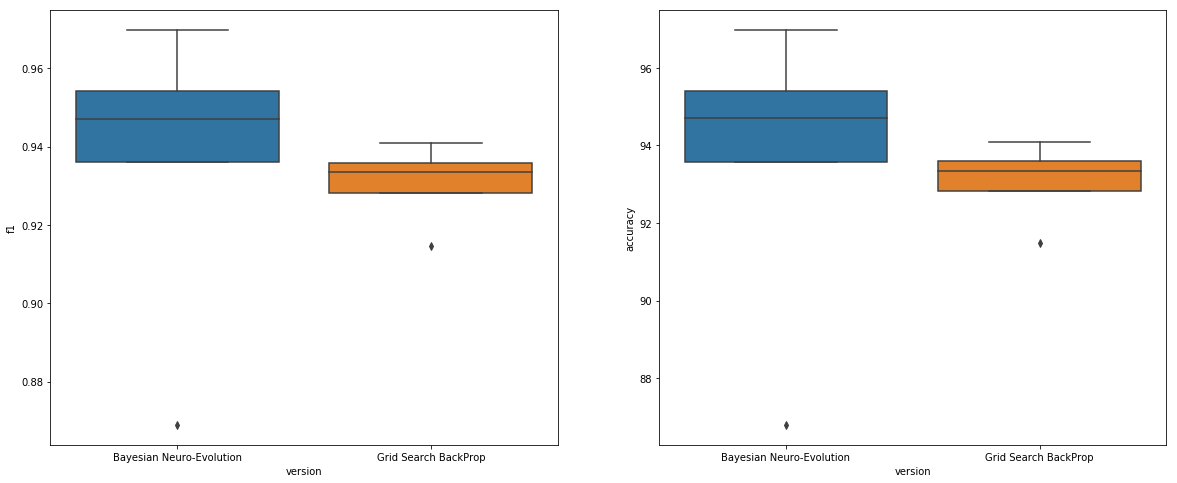

In [45]:
# sns.boxplot(data=data, y='accuracy', x='version')

_, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data=data, x='version', y='f1', ax=ax1)
sns.boxplot(data=data, x='version', y='accuracy', ax=ax2)
# ax1.set_ylim([0, 1])
# ax2.set_ylim([0, 100])

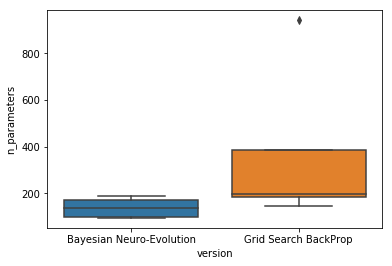

In [47]:
sns.boxplot(data=data, y='n_parameters', x='version')

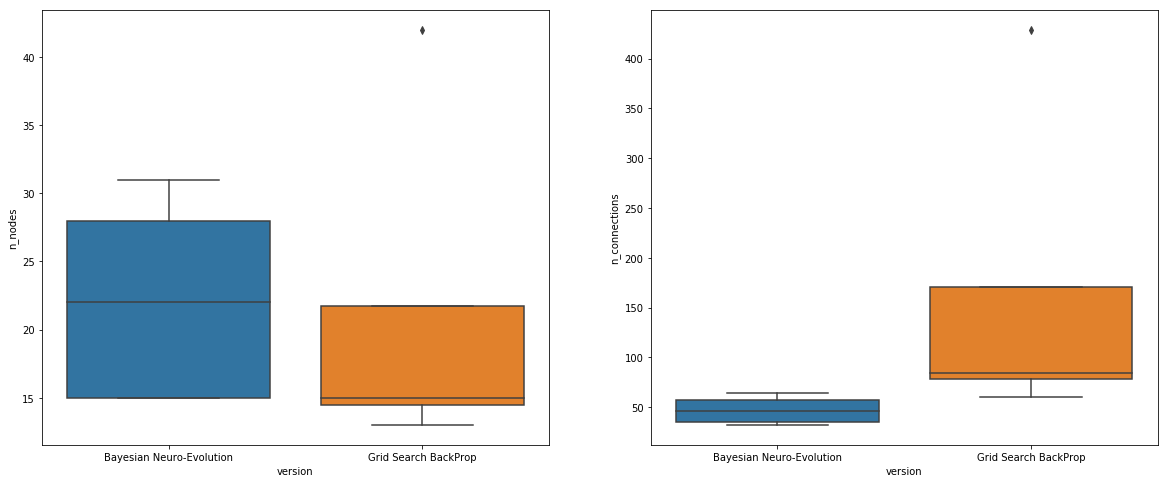

In [46]:
_, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data=data, x='version', y='n_nodes', ax=ax1)
sns.boxplot(data=data, x='version', y='n_connections', ax=ax2)

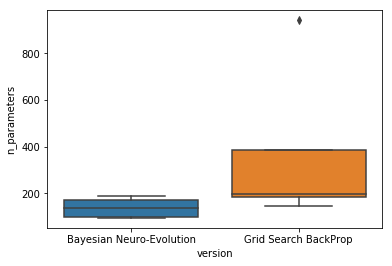

In [43]:
sns.boxplot(data=data, y='n_parameters', x='version')